In [1]:
import sys
import io
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf


# Fix for MacOS error:
# OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'



%matplotlib notebook

Using TensorFlow backend.


The main 'geoname' table has the following fields :
---------------------------------------------------
    geonameid         : integer id of record in geonames database
    name              : name of geographical point (utf8) varchar(200)
    asciiname         : name of geographical point in plain ascii characters, varchar(200)
    alternatenames    : alternatenames, comma separated, ascii names automatically transliterated, convenience attribute from alternatename table, varchar(10000)
    latitude          : latitude in decimal degrees (wgs84)
    longitude         : longitude in decimal degrees (wgs84)
    feature class     : see http://www.geonames.org/export/codes.html, char(1)
    feature code      : see http://www.geonames.org/export/codes.html, varchar(10)
    country code      : ISO-3166 2-letter country code, 2 characters
    cc2               : alternate country codes, comma separated, ISO-3166 2-letter country code, 200 characters
    admin1 code       : fipscode (subject to change to iso code), see exceptions below, see file admin1Codes.txt for display names of this code; varchar(20)
    admin2 code       : code for the second administrative division, a county in the US, see file admin2Codes.txt; varchar(80) 
    admin3 code       : code for third level administrative division, varchar(20)
    admin4 code       : code for fourth level administrative division, varchar(20)
    population        : bigint (8 byte int) 
    elevation         : in meters, integer
    dem               : digital elevation model, srtm3 or gtopo30, average elevation of 3''x3'' (ca 90mx90m) or 30''x30'' (ca 900mx900m) area in meters, integer. srtm processed by cgiar/ciat.
    timezone          : the iana timezone id (see file timeZone.txt) varchar(40)
    modification date : date of last modification in yyyy-MM-dd format

In [2]:
geoname_columns = ["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude", \
                   "feature_class", "feature_code", "country_code", "cc2", "admin1_code", "admin2_code", \
                   "admin3_code", "admin4_code", "population", "elevation", "dem", "timezone", "modification_date"]
raw_cities_data = pd.read_csv("data/cities500.txt", sep='\t', header=None, names=geoname_columns, index_col=0)
raw_cities_data

/Users/larag/miniconda3/envs/woher/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date
geonameid,,,,,,,,,,,,,,,,,,
3038999,Soldeu,Soldeu,NaN,42.57688,1.66769,P,PPL,AD,NaN,02,NaN,NaN,NaN,602,NaN,1832,Europe/Andorra,2017-11-06
3039154,El Tarter,El Tarter,"Ehl Tarter,Эл Тартер",42.57952,1.65362,P,PPL,AD,NaN,02,NaN,NaN,NaN,1052,NaN,1721,Europe/Andorra,2012-11-03
3039163,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",42.46372,1.49129,P,PPLA,AD,NaN,06,NaN,NaN,NaN,8022,NaN,921,Europe/Andorra,2013-11-23
3039604,Pas de la Casa,Pas de la Casa,"Pas de la Kasa,Пас де ла Каса",42.54277,1.73361,P,PPL,AD,NaN,03,NaN,NaN,NaN,2363,2050.0,2106,Europe/Andorra,2008-06-09
3039678,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",42.55623,1.53319,P,PPLA,AD,NaN,05,NaN,NaN,NaN,3066,NaN,1296,Europe/Andorra,2018-10-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895269,Beitbridge,Beitbridge,"Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be...",-22.21667,30.00000,P,PPL,ZW,NaN,07,NaN,NaN,NaN,26459,NaN,461,Africa/Harare,2013-03-12
895308,Beatrice,Beatrice,Beatrice,-18.25283,30.84730,P,PPL,ZW,NaN,04,NaN,NaN,NaN,1647,NaN,1307,Africa/Harare,2018-05-09
895417,Banket,Banket,"Banket,Banket Junction",-17.38333,30.40000,P,PPL,ZW,NaN,05,NaN,NaN,NaN,9641,NaN,1277,Africa/Harare,2013-03-12


# Dataset Cleanup

In [7]:
unwanted_columns = ["name", "alternatenames", "feature_class", "feature_code", \
                    "cc2", "admin1_code", "admin2_code", "admin3_code", "admin4_code", \
                    "population", "elevation", "dem", "timezone", "modification_date"]
df = raw_cities_data.drop(columns=unwanted_columns)              
print("Cleaning up dataset, before starting we have:")
print(f'{len(df)} city names from {len(set(df["country_code"].values))} countries')

df = df.dropna()
df["asciiname"] = df["asciiname"].str.lower() # Only lowercase for now
df["asciiname"] = df["asciiname"].str.replace(r"\(.*\)","") # Remove substrings within parenthesis
df["asciiname"] = df["asciiname"].str.replace(r"\[.*\]","") # Remove substrings within brackets
df["asciiname"] = df["asciiname"].str.replace(r'\".*\"',"") # Remove substrings within quotes
df["asciiname"] = df["asciiname"].str.replace(r"\'.*\'","") # Remove substrings within quotes
df = df.drop(df.index[df['asciiname'].str.contains('"').values]) # Remove remaining names that have a double quote in them
df["asciiname"] = df["asciiname"].map(lambda s: s.split("/")[0]) # If names has alt-name after slash, pick first
df["asciiname"] = df["asciiname"].str.strip() # Strip whitespace


print(f'{len(df)} city names from {len(set(df["country_code"].values))} countries')
print("... is what we ended up with at the end.")

unique_chars = sorted(list(set(df["asciiname"].str.cat())))
print(f'{len(unique_chars)} unique characters')

#df.where(df["asciiname"].str.contains("`")).dropna()

Cleaning up dataset, before starting we have:
192528 city names from 246 countries
192464 city names from 245 countries
... is what we ended up with at the end.
43 unique characters


# Dataset and Characters

In [197]:
NAME_BEGIN_CHAR = ">"
NAME_END_CHAR = "<"
LONGEST_NAME = df["asciiname"].str.len().max()
NAME_DIMENSION = LONGEST_NAME + 2 # Each name will be wrapper in begin/end characters

def pad_city_name(city_name):
    num_end_chars = 1 + LONGEST_NAME - len(city_name) # Pad all names with end char to have same length
    return NAME_BEGIN_CHAR + city_name + NAME_END_CHAR * num_end_chars


In [200]:
# Wrap all names in begin/end characters and pad them to same length
print(f"Longest city name was {LONGEST_NAME} characters, padding all names to match dimension.")
df["padded_name"] = df["asciiname"].map(pad_city_name)

# Create unqiue character list
CHARS = sorted(unique_chars + [NAME_BEGIN_CHAR, NAME_END_CHAR])
NUM_CHARS = len(CHARS)
print(f"Total number of unique characters including begin/end is {NUM_CHARS}")

# Create map for one-hot encoding of our characters
ONE_HOT_ENCODINGS = np_utils.to_categorical(range(NUM_CHARS))
ONE_HOT_MAP = {char : ONE_HOT_ENCODINGS[index] for index, char in enumerate(CHARS)}

Longest city name was 66 characters, padding all names to match dimension.
Total number of unique characters including begin/end is 45


In [283]:
def name_to_one_hot_x(row, memory=3):
    return np.array([ONE_HOT_MAP[c] for c in row["padded_name"][:-1]])

def name_to_one_hot_y(row):
    return np.array([ONE_HOT_MAP[c] for c in row["padded_name"][1:]])
    
def flatten_dataset(data_column):
    stacked = np.stack(data_column)
    return stacked.reshape(-1, stacked.shape[-1])
    
def one_hot_to_char(one_hot_char):
    hot_index = np.where(one_hot_char == 1)[0][0]
    return CHARS[hot_index]

def one_hot_to_name(one_hot_name):
    display(one_hot_name)
    assert(len(one_hot_name) == NAME_DIMENSION)
    assert(one_hot_name[0] == NAME_BEGIN_CHAR)
    assert(one_hot_name[-1] == NAME_END_CHAR)

    name = ""
    for one_hot_char in one_hot_name[1:]: # Skip start of name char
        char = one_hot_to_char(one_hot_char)
        if char == NAME_END_CHAR:
            return name
        else:
            name += char

def single_softmax_to_one_hot(softmax_char):
    hot_idx = np.argmax(softmax_char)
    return ONE_HOT_ENCODINGS[hot_idx]

def single_softmax_to_char(softmax_char):
    hot_idx = np.argmax(softmax_char)
    return CHARS[hot_idx]

def softmax_to_one_hot_name(softmax_array):
    return [single_softmax_to_one_hot(sm) for sm in softmax_array]

def softmax_to_name(softmax_array):
    return [single_softmax_char(sm) for sm in softmax_array]

In [340]:
def create_training_data_with_memory_for_row(row, model_memory=3):
    padded_name = model_memory * NAME_BEGIN_CHAR + row["padded_name"]
    result_x = []
    result_y = []

    for i in range(model_memory + 1, len(padded_name)):
        x = list(padded_name[i - model_memory : i])
        y = padded_name[i]
        result_x += [x]
        result_y += [y]
        if y == NAME_END_CHAR:
            break

    return {"x": np.array(result_x), "y": np.array(result_y)}


def one_hot_encode_char_array(char_array):
    return np.array([ONE_HOT_MAP[c] for c in char_array])
    

def create_training_data_with_memory(df, model_memory=3, num_samples=10000):
    training_sample_idx = np.random.randint(len(df), size=num_samples)
    training_samples = df.reset_index().iloc[training_sample_idx]
    
    nestled_training_data = training_samples.apply(lambda x: create_training_data_with_memory_for_row(x, model_memory), axis=1) 
    x_char = nestled_training_data.apply(pd.Series)["x"].explode().tolist()
    y_char = nestled_training_data.apply(pd.Series)["y"].explode().tolist()
    
    x_one_hot = np.apply_along_axis(one_hot_encode_char_array, -1, np.array(x_char))
    y_one_hot = np.apply_along_axis(one_hot_encode_char_array, -1, np.array(y_char))

    return x_one_hot, y_one_hot



In [341]:
X, Y = create_training_data_with_memory(df, model_memory=5, num_samples=10)

display(X.shape)
display(Y.shape)

(119, 5, 45)

(119, 45)

In [79]:
num_samples = 10000
training_sample_idx = np.random.randint(len(df), size=num_samples)
training_samples = df.reset_index().iloc[training_sample_idx]
nestled_training_data = training_samples.apply(create_training_data_with_memory_for_row, axis=1)#.apply(pd.Series)
#x = nestled_training_data.apply(pd.Series)["x"]#.apply(pd.Series).stack()
#y = nestled_training_data.apply(pd.Series)["y"].apply(pd.Series).stack()
#x, y


import time
start = time.process_time()
x = nestled_training_data.apply(pd.Series)["x"].apply(pd.Series).stack()
#x = nestled_training_data.apply(pd.Series)["x"].explode()
print(time.process_time() - start)

# 108502
# 2.807001999999997

x

4.735361000000012


78537  0    [>, >, >]
       1    [>, >, m]
       2    [>, m, a]
       3    [m, a, n]
       4    [a, n, i]
              ...    
94915  5    [j, a, l]
       6    [a, l, g]
       7    [l, g, a]
       8    [g, a, o]
       9    [a, o, n]
Length: 108502, dtype: object

## Model Architecture

In [332]:
# Model Parameters
model_memory = 4 # Number of characters of memory
input_shape = (model_memory, NUM_CHARS)

lstm_1_units = 128
lstm_1_activation = 'relu'
lstm_1_dropout = 0.3

dense_1_activation = 'softmax'
#class_weight=class_weight

# Model Architecture
model = Sequential()
model.add(LSTM(lstm_1_units,
               input_shape=input_shape,
               return_sequences=False,
               activation=lstm_1_activation,
               dropout=lstm_1_dropout))

model.add(Dense(NUM_CHARS, activation=dense_1_activation))

## Training Parameters and Data

In [344]:
num_training_samples = 30000

# Generate training data, can be slow
X, Y = create_training_data_with_memory(df, model_memory=model_memory, num_samples=num_training_samples)

display(X.shape)
display(Y.shape)

(321960, 4, 45)

(321960, 45)

In [345]:
batch_size = 10000
epochs = 5

optimizer = 'adam' #tf.train.RMSPropOptimizer(learning_rate=0.01) #
loss = 'categorical_crossentropy'


model.compile(loss=loss, optimizer=optimizer)

In [346]:
my_model = model.fit(X, Y, batch_size=batch_size, epochs=epochs)

Train on 321960 samples
Epoch 1/5
321960/321960 [==============================] - 21s 65us/sample - loss: 3.6535
Epoch 2/5
321960/321960 [==============================] - 19s 58us/sample - loss: 3.1116
Epoch 3/5
321960/321960 [==============================] - 18s 57us/sample - loss: 2.9682
Epoch 4/5
321960/321960 [==============================] - 18s 57us/sample - loss: 2.8286
Epoch 5/5
321960/321960 [==============================] - 18s 57us/sample - loss: 2.7224


<IPython.core.display.Javascript object>


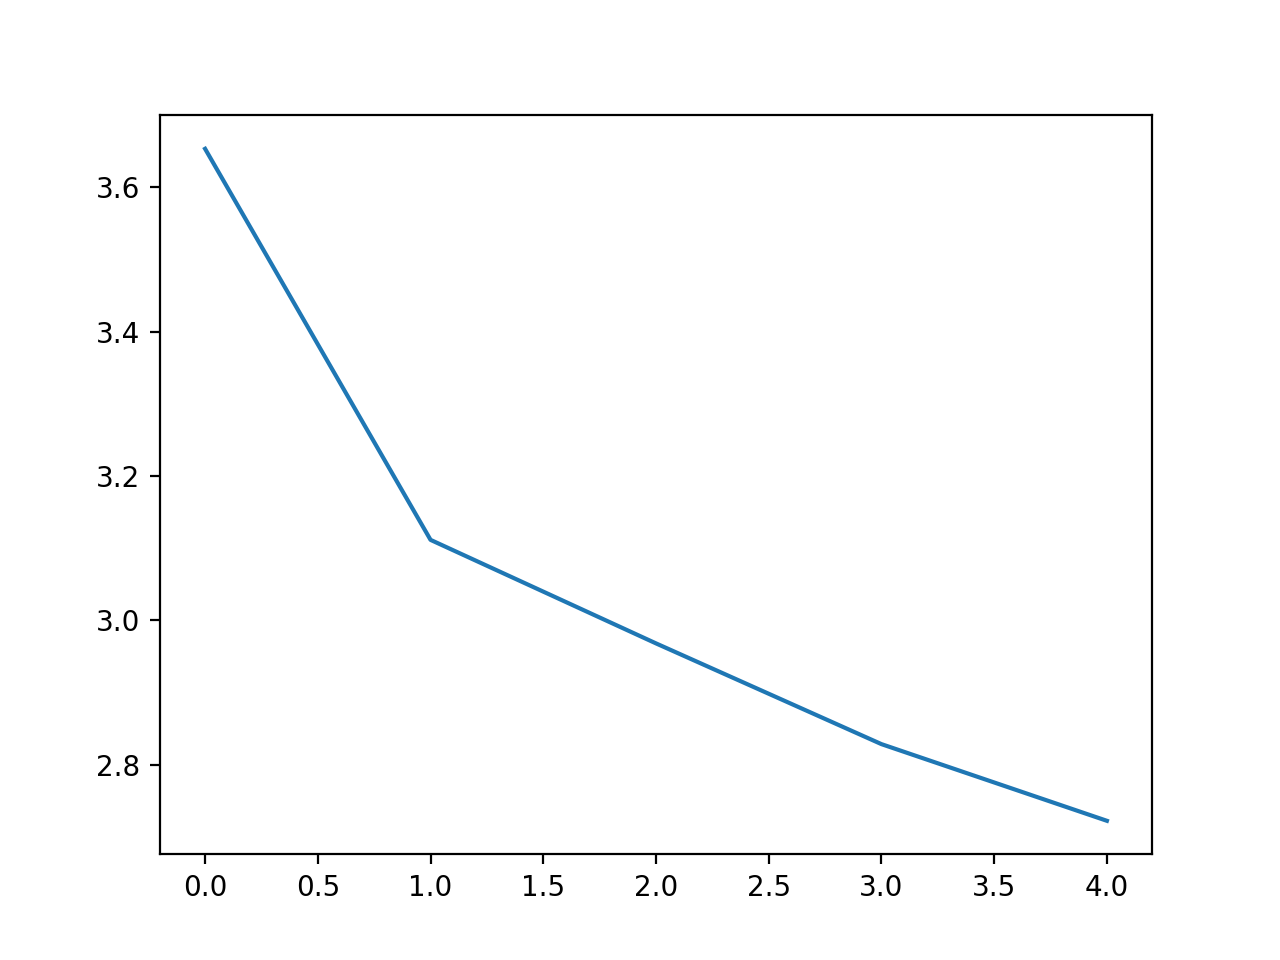

In [347]:
plt.plot(my_model.history['loss'])

In [356]:
#plt.figure()


def generate_name():
    previous_chars = X[0, :, :][np.newaxis, :, :]
    result = "".join([one_hot_to_char(oh) for oh in previous_chars[0]])
    for char_idx in range(NAME_DIMENSION):
        y = model.predict(previous_chars)
        new_char = single_softmax_to_char(y)
        if new_char == NAME_END_CHAR:
            return result
        result += single_softmax_char(y)
        new_char_one_hot = ONE_HOT_MAP[new_char][np.newaxis, :]
        previous_chars = np.append(previous_chars[0][1:], new_char_one_hot, axis=0)[np.newaxis, :, :]

    return result

generate_name()

'>>>>anan'

In [351]:
previous_chars = X[1, :, :][np.newaxis, :, :]
[one_hot_to_char(oh) for oh in previous_chars[0]]


['>', '>', '>', 's']